In [1]:
import numpy as np
import itertools
import random
import sys
import os
import timeit
import csv
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import collections 
from math import log

In [2]:
def Satisfy(M,list_of_clauses) :
    return ( np.array([True for i in range(len(list_of_clauses))]) == np.array([ 1 in [1 if (((M[abs(y)-1]==1) and y>0) or (((M[abs(y)-1]==0) and y<0))) else 0 for y in x ] for x in list_of_clauses])).sum()

In [3]:
def FindFalseVariablesInClause(M,list_of_clauses) :
    
    temp = [ x for x in list_of_clauses if (True not in [True if (((M[abs(y)-1]==1) and y>0) or (((M[abs(y)-1]==0) and y<0))) else False for y in x]) ]
    res = []
    for x in temp :
        for i in x :
            if(abs(i) not in res) :
                res.append(abs(i))
    return res


In [4]:
def FlipVariables(M,false_clause_variables,v) :
    if(v>=len(false_clause_variables)) :
        for i in range(len(false_clause_variables)): 
            M[false_clause_variables[i]-1]= 1 - M[false_clause_variables[i]-1]
    else :
        x = list(random.sample(false_clause_variables,v))
        random.shuffle(x)
        for i in x : 
            M[i-1]= 1 - M[i-1]
    return M 

In [5]:
def FindMinConflictingVVar(M,false_clause_variables,list_of_clauses,v) :
    if(v>=len(false_clause_variables)) :
        for i in range(len(false_clause_variables)):
            M[false_clause_variables[i]-1] = 1 - M[false_clause_variables[i]-1] 
    else :
        x = list(itertools.combinations(list(range(len(false_clause_variables))),v))
        random.shuffle(x)
        mx = Satisfy(M,list_of_clauses)
        model = tuple()
        for y in x : 
            for i in y :
                M[false_clause_variables[i]-1] = 1 - M[false_clause_variables[i]-1]      
            temp = Satisfy(M,list_of_clauses)
            if(mx<=temp) :
                mx = temp
                model = y 
            for i in y :
                M[false_clause_variables[i]-1] = 1 - M[false_clause_variables[i]-1]      
        for i in model :
            M[false_clause_variables[i]-1] = 1 - M[false_clause_variables[i]-1]      
    return M 

In [6]:
def WALKsat(file_name,DATA,maxv = 4,maxit = 500,p = .5) :
    with open(file_name,"r") as f :
        full_string = f.read() 
    list_of_clauses = full_string.split('\n')
    list_of_clauses = [st for st in list_of_clauses if len(st) != 0 and st[0] != 'c']

    n,m = tuple(list_of_clauses[0].split()[1:])
    list_of_clauses.remove(list_of_clauses[0])

    list_of_clauses = [st.split()[:len(st.split())-1] for st in list_of_clauses]
    list_of_clauses = [[int(y) for y in x] for x in list_of_clauses ]

    n = int(n)
    m = int(m)
    v = 0
    M = list(np.random.rand(n))
    M = [1 if x>.5 else 0 for x in M ]
    
    print(maxit,maxv,p,v)
    temp = maxit 
    
    count = 0
    start = timeit.timeit()  
    
    while (v<maxv) :
        v += 1
        maxit = temp
        while(maxit>0) :
            maxit -= 1
            if(Satisfy(M,list_of_clauses) == len(list_of_clauses)) :
                end = timeit.timeit()
                DATA.append([tuple((m,n)),(start-end),count])
                print("solution found for file : ",file_name)
                return 1
            false_clause_variables = FindFalseVariablesInClause(M,list_of_clauses)
            t = np.random.rand(1)[0]
            if(t>=p) :
                M = FlipVariables(M,false_clause_variables,v)
            else :
                M = FindMinConflictingVVar(M,false_clause_variables,list_of_clauses,v)
            count += 1
    end = timeit.timeit()
    DATA.append([tuple((m,n)),(start-end),count])
    print("solution NOT found for file : ",file_name)
    return 0   

In [7]:
def csv_creation(no_iter=10) :
    DATA=[]
    gf = os.listdir("findata")
    os.chdir("./findata")

    if ".DS_Store" in gf :
        gf.remove(".DS_Store")

    dic_file_IterData = {"fileNumber" : [] ,"fileName":[]} 
    dic_file_IterData["fileNumber"] = [None]*len(gf)
    dic_file_IterData["fileName"] = [None]*len(gf)

    for j in range(1,no_iter+1) :
        count = 0
        dic_file_IterData["iter"+str(j)+":m/nratio"] = [None]*len(gf)
        dic_file_IterData["iter"+str(j)+":time"] = [None]*len(gf)
        dic_file_IterData["iter"+str(j)+":noOfIter"] = [None]*len(gf)
        for m in gf :
            print("file is :",m)
            WALKsat(m,DATA)
            DATA=DATA[0]
            if j == 1 :
                dic_file_IterData["fileNumber"][count] = count+1 
                dic_file_IterData["fileName"][count] = m
            dic_file_IterData["iter"+str(j)+":m/nratio"][count] = DATA[0][0]/DATA[0][1]
            dic_file_IterData["iter"+str(j)+":time"][count] = DATA[1]
            dic_file_IterData["iter"+str(j)+":noOfIter"][count] = DATA[2]
            count = count + 1
            DATA.clear()
    df = pd.DataFrame(dic_file_IterData) 
    df.to_csv('../important_info.csv')
    os.chdir("..")
    return "important_info.csv"

In [8]:
# df = pd.read_csv("important_info.csv",index_col=0) 
# print(df.columns)
# # df.columns = ["index",'fileNumber', 'fileName', 'iter1:m/nratio', 'iter1:time',
# #        'iter1:noOfIter', 'iter2:m/nratio', 'iter2:time',
# #        'iter2:noOfIter', 'iter3:m/nratio', 'iter3:time',
# #        'iter3:noOfIter', 'iter4:m/nratio', 'iter4:time',
# #        'iter4:noOfIter', 'iter5:m/nratio', 'iter5:time',
# #        'iter5:noOfIter', 'iter6:m/nratio', 'iter6:time',
# #        'iter6:noOfIter', 'iter7:m/nratio', 'iter7:time',
# #        'iter7:noOfIter', 'iter8:m/nratio', 'iter8:time',
# #        'iter8:noOfIter', 'iter9:m/nratio', 'iter9:time',
# #        'iter9:noOfIter', 'iter10:m/nratio', 'iter10:time',
# #        'iter10:noOfIter']
# # df.to_csv('important_info.csv') 

# df = df.drop(columns =['Unnamed: 0.1'])
# print(df.columns)
# df.to_csv('important_info.csv') 


In [5]:
def graph_plotting(file_name,no_iter=1) :
    df = pd.read_csv(file_name,index_col=0)
    time = list([0.0]*(len(df["fileName"])))
    ite = list([0.0]*(len(df["fileName"])))
    mnratio = list([0.0]*(len(df["fileName"])))
    for count in range(len(list(df["fileName"]))) :
        for j in range(1,no_iter+1) :
            time[count] = float(time[count] + df["iter"+str(j)+":time"][count])
            ite[count] = float(ite[count] + df["iter"+str(j)+":noOfIter"][count])
        ite[count] = float(ite[count]/no_iter)
        time[count] =float(time[count]/no_iter)
        mnratio[count] = float(df["iter1:m/nratio"][count])
    df["avgIter"]= ite
    df["avgTime"]= time
    df["mnratio"]= mnratio
    
    df.to_csv('important_info.csv') 
    
    #print(df)
    
    res=dict(zip(list(df["mnratio"]),list(df["avgIter"])))
    od = collections.OrderedDict(sorted(res.items()))
    figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(od.keys(),od.values())
    plt.xlabel('mnratio')
    plt.ylabel('meantime')
    plt.show()
    


    figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(od.keys(),[log(y,2) if y>0 else 0 for y in od.values()])
    plt.xlabel('mnratio')
    plt.ylabel('log(meantime)')
    figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
    plt.show()

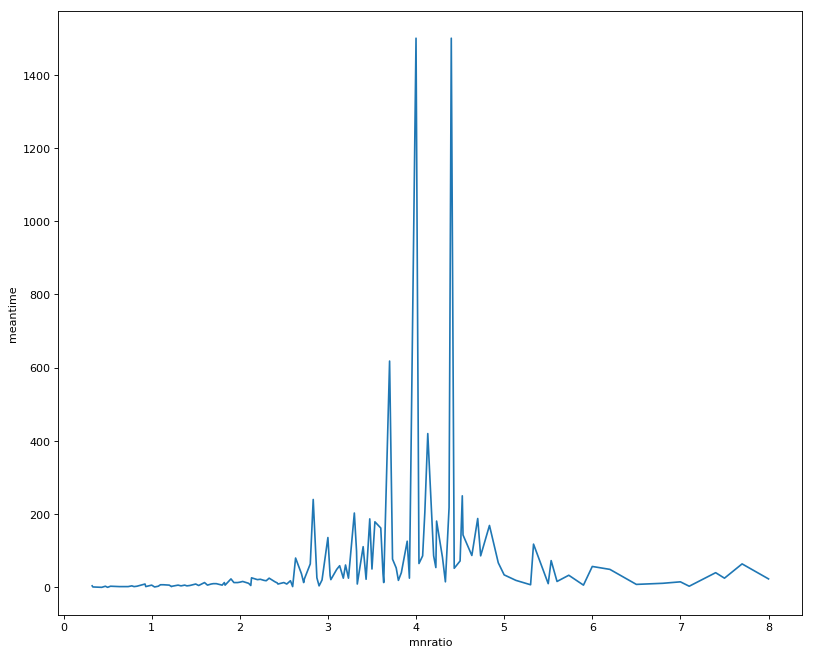

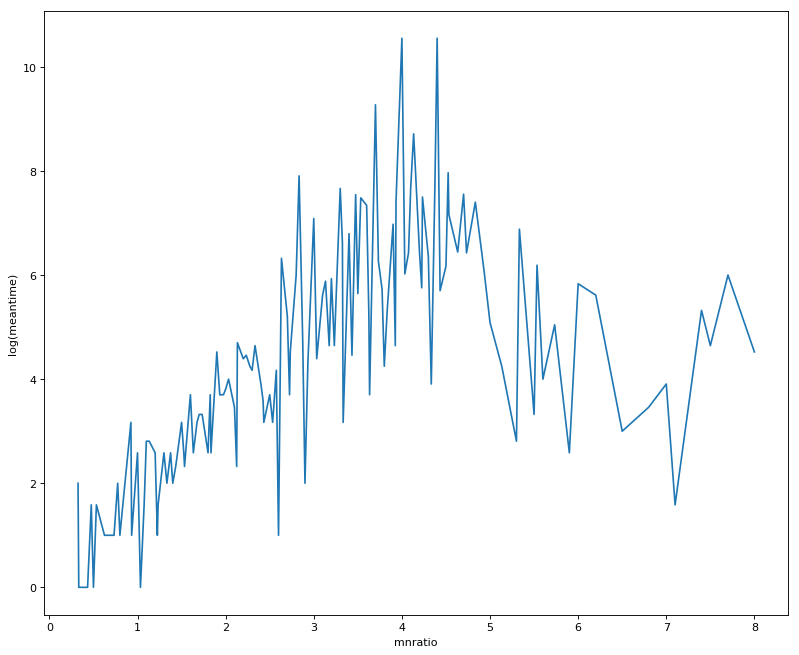

<Figure size 960x800 with 0 Axes>

In [6]:
# no_iter = int(input("give no of iteration to iterate on each file."))
# graph_plotting(csv_creation(no_iter),no_iter)
graph_plotting("important_info.csv",1)